In [287]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import sympy                                                         # symbolic library
from sympy.abc import x, y                                           # in all code x and y are treated as symbolic variables
from sympy.utilities.lambdify import lambdify, implemented_function  # for convert from symbolic to numerical
from sympy.interactive import printing
printing.init_printing(use_latex=True)

## Building conductor class

In [225]:
class Condutor(object):
    '''The Donductor class:
    It creat a conductor that can be put in a TransmissionLine class (possibly).
    x: is the x position in the plane x-y
    y: is the y position in the plane x-y
    r_ext: The external radio of the conductor
    r_int: The internal radio of the conductor. Default is zero'''
    
    def __init__(self, x, y, r_ext, r_int=0):
        self.xc = x
        self.yc = y
        self.rinternal = r_int
        self.rexternal = r_ext
        self.area_condutor = np.pi*(r_ext**2 - r_int**2)
        self.phase = None
        self.charges = None
    
    @property
    def x_position(self):
        return self.xc
    @property
    def y_position(self):
        return self.yc
    @property
    def r_internal(self):
        return self.r_internal
    @property
    def r_external(self):
        return self.r_external
    @property
    def area(self):
        return self.area_condutor
    @property
    def fase(self):
        return self.phase
    @property
    def charge(self):
        return self.charges
    
    
    @x_position.setter
    def x_position(self,x):
        self.xc = x
    @y_position.setter
    def y_position(self,yc):
        self.yc = y
    @fase.setter
    def fase(self,phase):
        self.phase = phase
    @charge.setter
    def charge(self,q):
        self.charges = q
        

## Variables definitions

In [325]:
sigma_solo = 0.001    # solo's conductivity 
epsilon = 83854e-12   # permittivity in all regions
mi = 4.*np.pi*1e-7    # premeabilty in all regions except in the ligthning wires
m_r = 100.            # relative permittivity
r_int = 0.003995      # internal radius
r_ext = 0.01598       # external radius
number_cables = 6

u = 500e3             # Voltage maximum amplitude (V)
p = 1000e6            # Potence in a phase    (W)
i = p/u               # The current per cable (A)
w = 2*np.pi*60        # angular frequency (rad/s)

p = np.sqrt(1/(1j*w*mi*sigma_solo))

phase_line = {'a': 0 , 'b':-120, 'c':120}

# the last two conductors are the ligthning conductors ---------------------------------------------------------------
xy = np.array([[-6,17],[-6,27.8],[-6,37],[6,17],[6,27.8],[6,37],[-8,55],[8,55]])  # the position matrix of eacho cable
a,b = np.hsplit(xy,2)
xc = np.transpose(a)[0]
yc = np.transpose(b)[0]

In [326]:
# for test


(1027.3407401024997-1027.3407401024997j)

## Functions

In [327]:
# create a list of conductos
def create_conductor(x,y,r_e,r_i=0):
    '''Description: Create a list of conductor objects from Conductor class.
    
    x: The x position list
    y: The y position list
    r_e: The external radius
    r_i: The internal radius'''
    
    aux_list = []
    for i in range(0,len(x)):
        c = Condutor(x[i],y[i],r_ext,r_int)
        aux_list.append(c)
    return aux_list


# define the equivalent conductor
def equivalent_radius(r_e,R,N):
    '''Return the equivalent radius of a conductor beam'''
    r_equivalent = (N*r_e*(R**(N-1)))**(1./N)
    return r_equivalent

# The Maxwell's potential matrix
def pot_matrix(x,y,rf,rp,nc=6):
    matrix = []
    for i in range(0,len(xc)):
        aux_list = []
        for j in range(0,len(yc)):
            if i!=j:
                calculo = 0.5*np.log(((y[i]+y[j]+2*p)**2+(x[i]-x[j])**2)/((y[i]-y[j])**2+(x[i]-x[j])**2))
                aux_list.append(calculo)
            elif i<=nc:
                calculo = np.log(2*(y[i]+p)/rf)
                aux_list.append(calculo)
            else:
                calculo = np.log(2*(y[i]+p)/rp)
                aux_list.append(calculo)
        matrix.append(aux_list)
    matrix = np.array(matrix)
    return matrix

# Voltage list
def volts(theta):
    '''Description: returns a matrix coteined the potential value for each conductor'''
    angle = np.radians(theta)
    volts = []
    for k in conductors:
        if k.fase == None:
            volts.append(0)
        else:
            a = u*np.cos(angle+ np.radians(k.fase))
            volts.append(a)
    return volts

# all charges cointeined in each cable
def total_charge(theta):
    qq = (2*np.pi*epsilon)*np.linalg.inv(pot_matrix(xc,yc,equivalent_radius(r_ext,0.2,4.),equivalent_radius(r_ext,0.2,4.)))@volts(theta)
    for k in range(0,len(qq)):
        conductors[k].charge = qq[k]
    return qq

# chamar primeiro total_charge() e depois potencial_eletrico()
    
def electric_potential(theta,x1=None,y1=None):
    pot_aux = 0.
    total_charge(theta)
    alpha = 1./(4*np.pi*epsilon)
    for k in conductors:
        pot_aux+= alpha*(k.charge/((x-k.x_position)**2+(y-k.y_position)**2)**0.5 -k.charge/((x+k.x_position)**2+(y+k.y_position)**2)**0.5 )
    return pot_aux
        
        

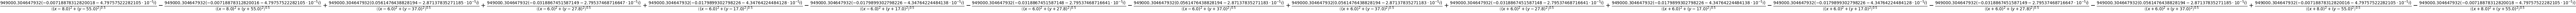

In [328]:
electric_potential(0)

## Set the conductors parameters

In [229]:
conductors = create_conductor(xc,yc,r_ext,r_int) # create a list of conductors
c1 = conductors[0]
c2 = conductors[1]
c3 = conductors[2]
c4 = conductors[3]
c5 = conductors[4]
c6 = conductors[5]
pr1 = conductors[6]
pr2 = conductors[7]
# for set the phase conductors
c3.fase = c6.fase = phase_line['a'] 
c2.fase = c5.fase = phase_line['b']
c1.fase = c4.fase = phase_line['c']


In [142]:
#for test

## For plotting

In [292]:
%matplotlib notebook

In [379]:
xx,yy = np.meshgrid(np.linspace(-15,15,80),np.linspace(-75,75,300))

def plot_equipotential(theta):
    symbolical_pot = electric_potential(theta)
    numerical_pot = lambdify((x,y),symbolical_pot,'numpy')
    fig, ax = plt.subplots(figsize=(10,10))       # choosing the plot size
    c = plt.contourf(xx,yy,numerical_pot(xx,yy),900,cmap='jet',alpha=0.3)
    ax.contour(xx,yy,numerical_pot(xx,yy),950,cmap='jet')
    
    plt.colorbar(c)
    plt.show()

<IPython.core.display.Javascript object>


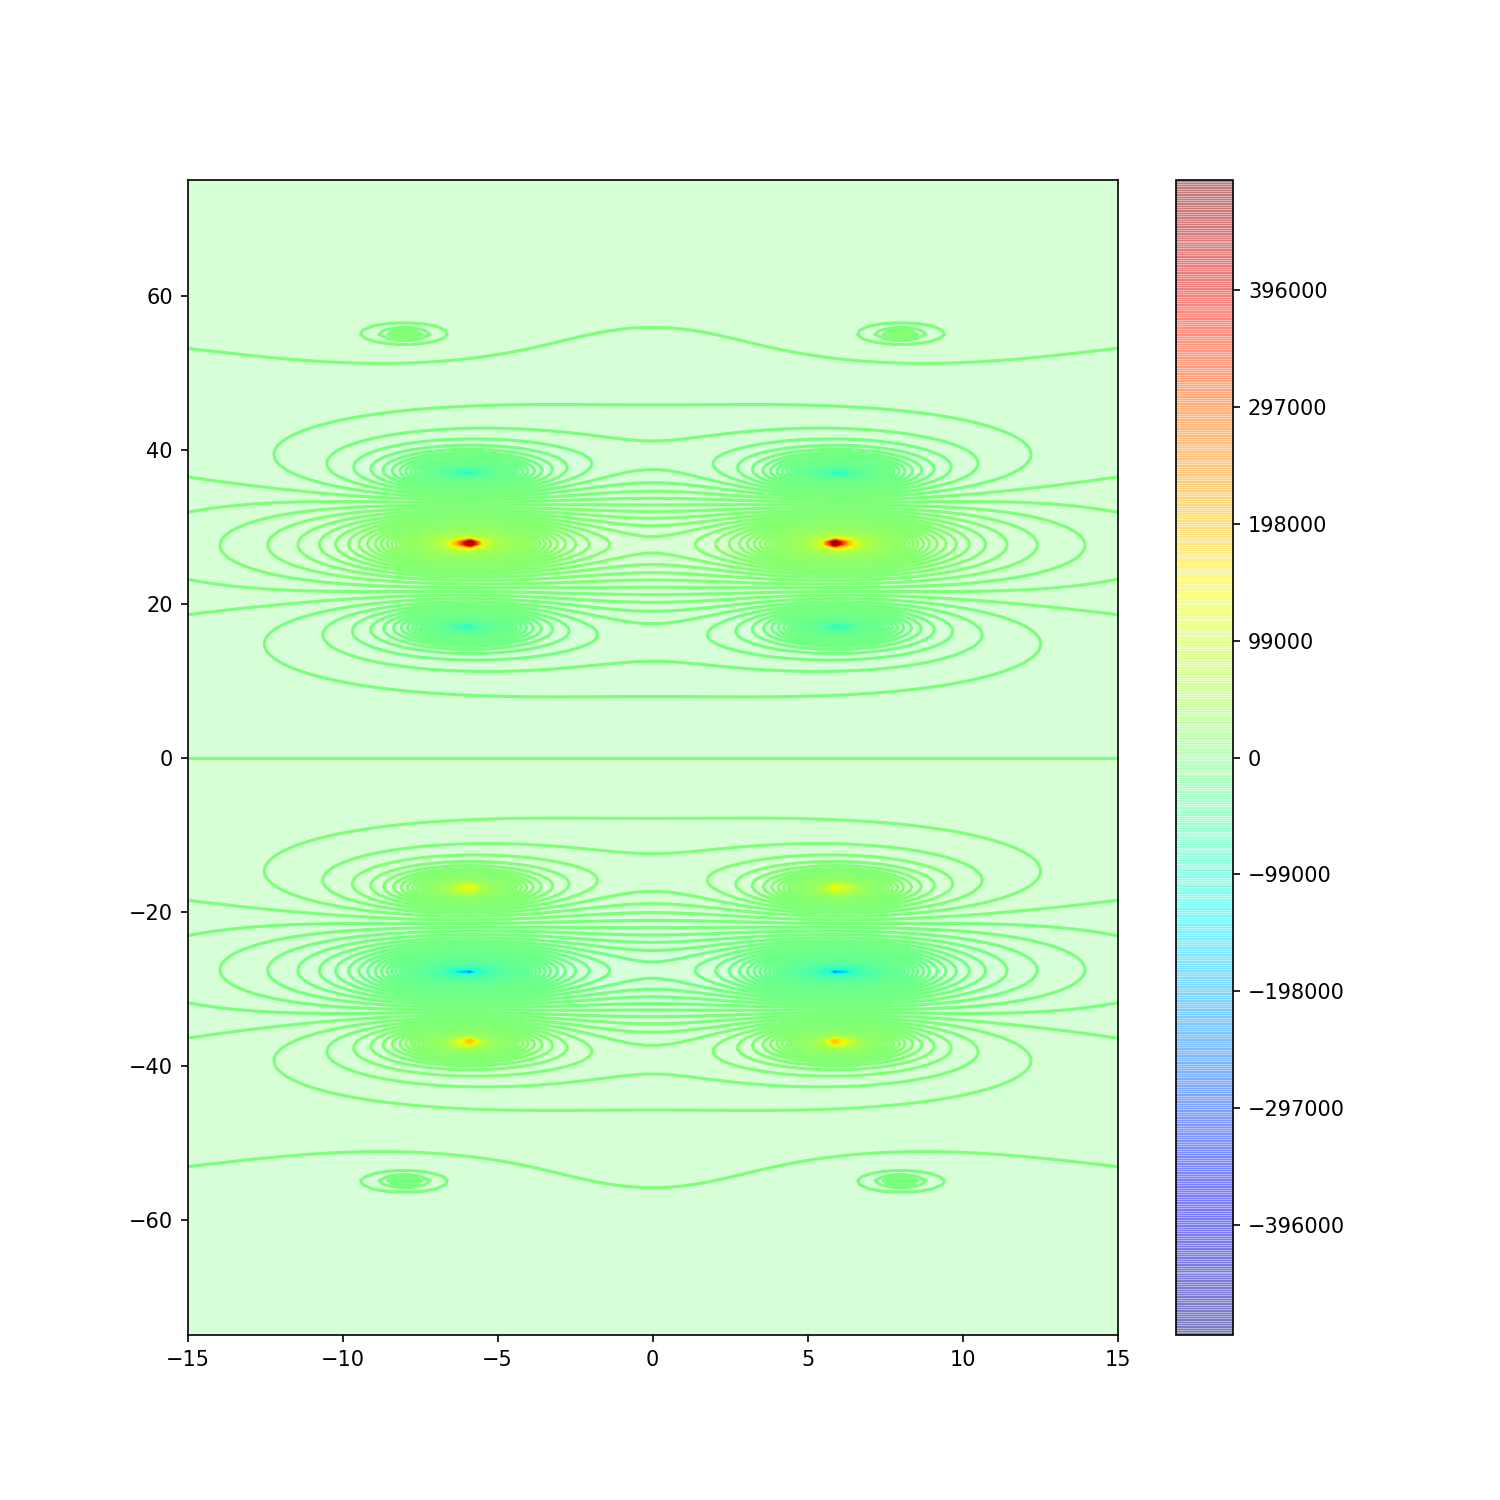

C:\Users\Carlos\Anaconda3\envs\oldqt\lib\site-packages\numpy\ma\core.py:2785: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


In [380]:
plot_equipotential(120)

In [354]:
x1,y1 = np.arange(-20,20,0.5) , np.arange(0,0,100) 

<IPython.core.display.Javascript object>


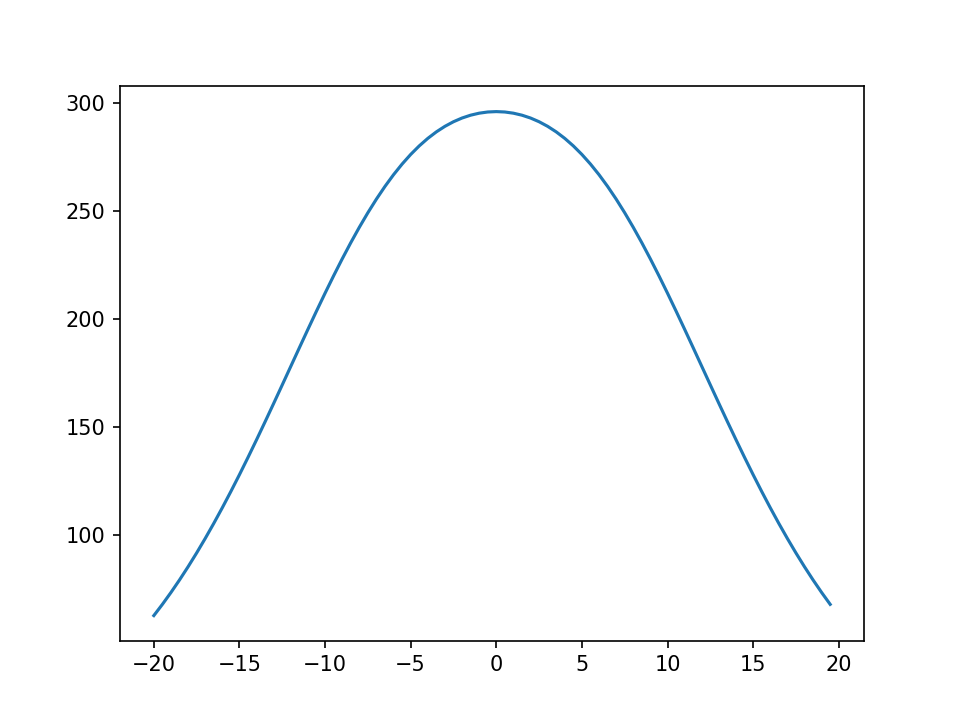

In [355]:
x1

array([-20. , -19.5, -19. , -18.5, -18. , -17.5, -17. , -16.5, -16. ,
       -15.5, -15. , -14.5, -14. , -13.5, -13. , -12.5, -12. , -11.5,
       -11. , -10.5, -10. ,  -9.5,  -9. ,  -8.5,  -8. ,  -7.5,  -7. ,
        -6.5,  -6. ,  -5.5,  -5. ,  -4.5,  -4. ,  -3.5,  -3. ,  -2.5,
        -2. ,  -1.5,  -1. ,  -0.5,   0. ,   0.5,   1. ,   1.5,   2. ,
         2.5,   3. ,   3.5,   4. ,   4.5,   5. ,   5.5,   6. ,   6.5,
         7. ,   7.5,   8. ,   8.5,   9. ,   9.5,  10. ,  10.5,  11. ,
        11.5,  12. ,  12.5,  13. ,  13.5,  14. ,  14.5,  15. ,  15.5,
        16. ,  16.5,  17. ,  17.5,  18. ,  18.5,  19. ,  19.5])